# Appendix

This notebook loads the pre-trained models and analyses the influence of hyper parameters on the neural network with two hidden layers. It performs the following steps:
1. Loads and preprocesses the data.
2. Analysis of the influence of the number of epochs while training
3. Analysis of the influence of the input timespan

Each analysis compares the Mean Squared Error (MSE) on the training and validation data for the two-hidden-layer neural network, as a function of the hyperparameter being examined. To reduce the impact of random weight and bias initialization, the MSE was averaged over 10 independent training runs, each using a newly initialized network.

### Appedix: of not shown but mentioned results of the model analysis for the neural network with two hidden layers

### 4.1 Setup and Data Preparation

#### Import Data from the Data exploration file

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

In [20]:
%%capture
from ipynb.fs.full.data_exploration import df_sealevel, GHG_past_comb, df_pred

In [21]:
# Add src directory to path to import neural_networks module
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from neural_networks import NeuralNetwork_0hl, NeuralNetwork_2hl

# Set random seed for reproducibility
np.random.seed(42)

# Prepare the data for normalization
df_sealevel = df_sealevel.groupby(df_sealevel.Day.dt.year).mean()
df_sealevel = df_sealevel.drop('Day', axis=1, errors='ignore')
df_pred = df_pred.rename(columns={'Trend from implemented policies (Lowest bound of  red shading ) ': 'Trend from implemented policies','Limit warming to 2°C (>67%) or return warming to 1.5°C (>50%) after a high overshoot, NDCs until 2030 (Median , dark navy blue line )': 'Limit warming to 2°C or return warming to 1.5°C after a high overshoot', 'Limit warming to 2°C (>67%) (Median , dark green line )': 'Limit warming to 2°C', 'Limit warming to 1.5°C (>50%) with no or limited overshoot ( Median ligh blue line ) ': 'Limit warming to 1.5°C'})

# Normalization 
GHG_past_norm = (GHG_past_comb - GHG_past_comb.mean()) / GHG_past_comb.std()
sealevel_norm = (df_sealevel - df_sealevel.mean()) / df_sealevel.std()

# Sequence and Splitting 
def get_GHG_sequence(n_years, df_GHG, start_year, end_year):
    X, y = list(), list()
    for i in range(start_year, end_year + 1):
        end_ix = i - 1
        start_ix = end_ix - n_years + 1
        seq_x = df_GHG.loc[start_ix:end_ix]
        X.append(seq_x.to_numpy())
        y.append(sealevel_norm.loc[i].values)
    return np.array(X), np.array(y)

timespan = 15               ### WHY???????
train_end_year = 2000
validation_end_year = 2007
test_end_year = 2014

X_train, y_train = get_GHG_sequence(timespan, GHG_past_norm, 1970, train_end_year)
X_val, y_val = get_GHG_sequence(timespan, GHG_past_norm, train_end_year + 1, validation_end_year)
X_test, y_test = get_GHG_sequence(timespan, GHG_past_norm, validation_end_year + 1, test_end_year)

### 4.2 Analysis: Prevent overfitting for the two hidden layer neural network

The following overfitting analysis requires significant processing time. To expedite the review process, we have included a pre-generated image of the results below, alongside the code used to perform the analysis.

In [ ]:
np.random.seed()
arr_mse_train_overfit, arr_mse_vali_overfit = [],[]

for n_epochs in np.logspace(4, 6.5, num=20):
    
    sum_mse_train_overfit, sum_mse_vali_overfit = 0, 0

    for _ in range(100):
         
        # Train the NN
        nn = NeuralNetwork_2hl(input_size=timespan, hidden_size1=8, hidden_size2=4, output_size=1)
        mse_train = nn.train(np.squeeze(X_train), y_train.reshape(-1, 1), epochs=int(n_epochs), learningrate = .001, print_output = False)
        
        # Create predictions for validation set
        pre_vali = nn.predict(np.array([np.squeeze(X_val)]))

        #  Add the MSE (for calculation of the mean)
        sum_mse_vali_overfit += np.mean(np.square(y_val - pre_vali))
        sum_mse_train_overfit += mse_train[-1]

        # Print error message if the MSE doesn't coverge
        if round(mse_train[-1],4) != round(mse_train[-2],4):
            print('Epochs: ' + str(int(n_epochs)) + '    Error: Not enough epochs!')

        # Calculate the mean        
    arr_mse_train_overfit += [sum_mse_train_overfit/100]
    arr_mse_vali_overfit += [sum_mse_vali_overfit/100]

    print('Epochs: ' + str(int(n_epochs)) + '   MSE = ' + str(round(arr_mse_train_overfit[-1],4)))

Epochs: 10000    Error: Not enough epochs!
Epochs: 10000    Error: Not enough epochs!
Epochs: 10000   MSE = 0.1288
Epochs: 13538    Error: Not enough epochs!
Epochs: 13538   MSE = 0.1355
Epochs: 18329    Error: Not enough epochs!
Epochs: 18329    Error: Not enough epochs!
Epochs: 18329    Error: Not enough epochs!
Epochs: 18329   MSE = 0.1218
Epochs: 24816    Error: Not enough epochs!
Epochs: 24816    Error: Not enough epochs!
Epochs: 24816   MSE = 0.1231
Epochs: 33598    Error: Not enough epochs!
Epochs: 33598    Error: Not enough epochs!
Epochs: 33598   MSE = 0.1266
Epochs: 45487   MSE = 0.1249
Epochs: 61584   MSE = 0.1464
Epochs: 83378    Error: Not enough epochs!
Epochs: 83378    Error: Not enough epochs!
Epochs: 83378    Error: Not enough epochs!
Epochs: 83378   MSE = 0.1246
Epochs: 112883    Error: Not enough epochs!
Epochs: 112883   MSE = 0.1319
Epochs: 152830    Error: Not enough epochs!
Epochs: 152830   MSE = 0.1117
Epochs: 206913   MSE = 0.1381
Epochs: 280135    Error: Not en

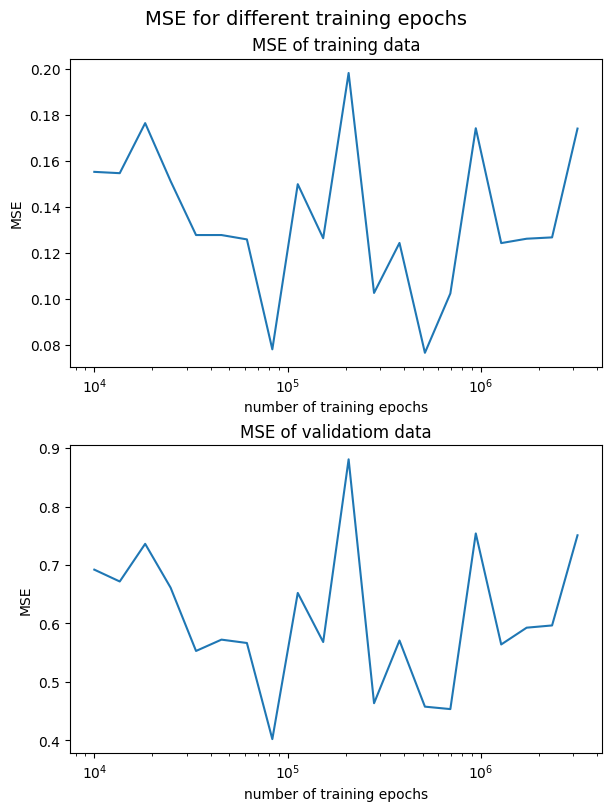

In [9]:
# Plot the results of the MSE for different epochs
arr_epochs = np.logspace(4, 6.5, num=20)
arr_epochs = arr_epochs.astype(np.int64)
fig=plt.figure(figsize=(6,8),layout='constrained')
fig.suptitle(r'MSE for different training epochs', fontsize=14)
ax1=fig.add_subplot(211)
ax1.plot(arr_epochs,arr_mse_train_overfit)
ax1.set_title(r'MSE of training data')
ax2=fig.add_subplot(212)
ax2.plot(arr_epochs,arr_mse_vali_overfit)
ax2.set_title(r'MSE of validatiom data')
for ax in [ax1,ax2]:
    ax.set_xscale('log')
    ax.set_xlabel('number of training epochs')
    ax.set_ylabel('MSE')
fig.savefig('images/analysis_training_epochs_2hl.png')

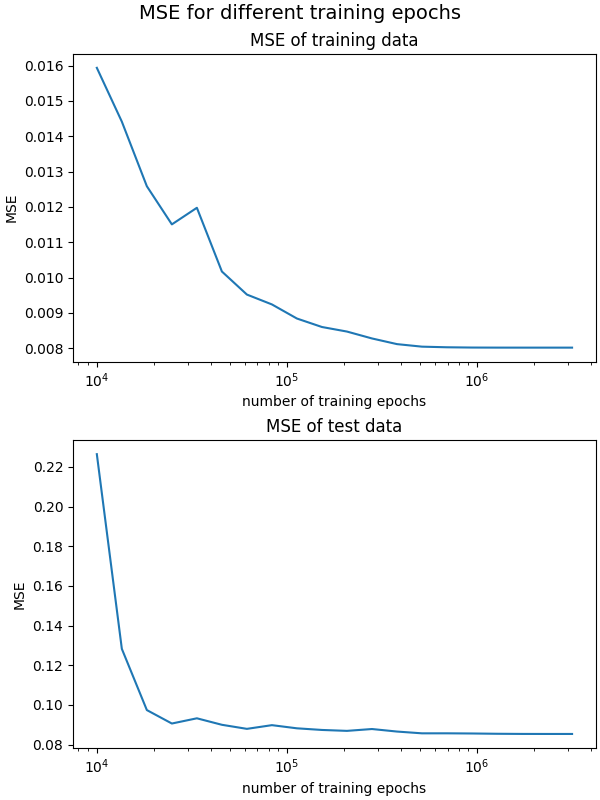

In [ ]:
# Pre-generated image of the overfitting analysis
from IPython.display import Image
Image(filename='images/analysis_training_epochs_2hl.png')

In [10]:
print('The number of epochs with the smallest MSE for the validation data is: ' + str(arr_epochs[np.argmin(arr_mse_vali_overfit)]))

The number of epochs with the smallest MSE for the validation data is: 83378


This plot shows the Mean Squared Error (MSE) on the training and validation data for the neural network with two hidden layers. The x-axis represents the number of training epochs. To mitigate the impact of random weight and bias initialization, the MSE was averaged over 10 independent training runs, each with a newly initialized neural network. The results are used in the model_analysis notebook for comparison with the single-layer neural network.

### 4.3 Analysis of the influence of the input timespan for the two hidden layer neural network

Similar to the previous analysis, determining the influence of the input timespan requires substantial processing time. To facilitate review, we have again included a pre-generated image of the results alongside the code.

In [ ]:
arr_mse_train, arr_mse_vali = [],[]
y_data = np.array(sealevel_norm.loc[1970:2014])

for timespan in np.arange(10,101,5):

    # Split the data
    X_train_loop, y_train_loop = get_GHG_sequence(timespan, GHG_past_norm, 1970, train_end_year)
    X_vali_loop, y_vali_loop = get_GHG_sequence(timespan, GHG_past_norm, train_end_year + 1, validation_end_year)

    sum_mse_train, sum_mse_vali = 0, 0

    for _ in range(100):

        # Train the NN
        nn = NeuralNetwork_2hl(input_size=timespan, hidden_size1=8, hidden_size2=4, output_size=1)
        mse_train = nn.train(np.squeeze(X_train_loop), y_train_loop.reshape(-1, 1), epochs=10**5, learningrate = .001, print_output = False)
        
        # Create predictions for test set
        pre_vali = nn.predict(np.array([np.squeeze(X_vali_loop)]))

        # Add the MSE (for calculation of the mean)
        sum_mse_vali += np.mean(np.square(y_vali_loop - pre_vali))
        sum_mse_train += mse_train[-1]

        # Print error message if the MSE doesn't coverge
        if round(mse_train[-1],4) != round(mse_train[-2],4):
            print('Timespan: ' + str(timespan) + ' years:    Error: Not enough epochs!')

    # Calculate the mean        
    arr_mse_train += [sum_mse_train/100]
    arr_mse_vali += [sum_mse_vali/100]

    print('Timespan: ' + str(timespan) + ' years: MSE = ' + str(round(arr_mse_train[-1],4)))

Timespan: 10 years: MSE = 0.1995
Timespan: 15 years:    Error: Not enough epochs!
Timespan: 15 years: MSE = 0.1746
Timespan: 20 years: MSE = 0.1736
Timespan: 25 years: MSE = 0.0849
Timespan: 30 years: MSE = 0.1261
Timespan: 35 years:    Error: Not enough epochs!
Timespan: 35 years: MSE = 0.1496
Timespan: 40 years: MSE = 0.1006
Timespan: 45 years: MSE = 0.0528
Timespan: 50 years: MSE = 0.0964
Timespan: 55 years: MSE = 0.0566
Timespan: 60 years: MSE = 0.1486
Timespan: 65 years: MSE = 0.0772
Timespan: 70 years: MSE = 0.1972
Timespan: 75 years: MSE = 0.1501
Timespan: 80 years: MSE = 0.1507
Timespan: 85 years: MSE = 0.2232
Timespan: 90 years: MSE = 0.1752
Timespan: 95 years: MSE = 0.1781
Timespan: 100 years: MSE = 0.2233


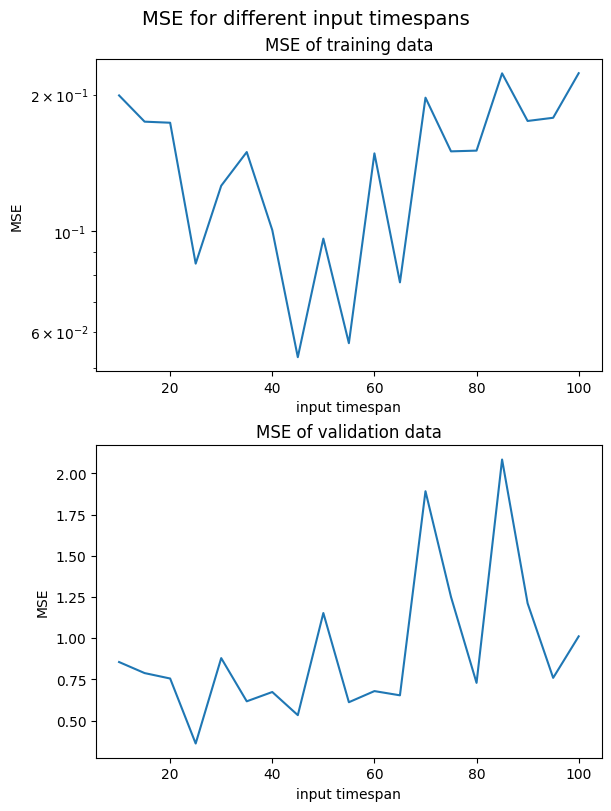

In [14]:
# Plot the results of the MSE for different input timespans
arr_timespans = np.arange(10,101,5)
fig=plt.figure(figsize=(6,8),layout='constrained')
fig.suptitle(r'MSE for different input timespans', fontsize=14)
ax1=fig.add_subplot(211)
ax1.plot(arr_timespans,arr_mse_train)
ax1.set_yscale('log')
ax1.set_title(r'MSE of training data')
#ax1.axis([9, 101,10**(-12), 10**(-1)])
ax2=fig.add_subplot(212)
ax2.plot(arr_timespans,arr_mse_vali)
ax2.set_title(r'MSE of validation data')
#ax2.axis([9, 101,0, 0.2])
for ax in [ax1,ax2]:
    ax.set_xlabel('input timespan')
    ax.set_ylabel('MSE')
fig.savefig('images/analysis_input_timespan_2hl.png')

In [ ]:
# Pre-generated image of the analysis of the influence of the input timespan
from IPython.display import Image
Image(filename='images/analysis_input_timespan_2hl.png')

Similar to the analysis above the results of this plot are used in the model_analysis notebook for comparison with the single-layer neural network. This plot shows the Mean Squared Error (MSE) on the training and validation data for the neural network with two hidden layers. The x-axis represents the used input timespan of GHG emissions while training the data. To mitigate the impact of random weight and bias initialization, the MSE was averaged over 10 independent training runs, each with a newly initialized neural network.

In [16]:
# Counter test 

np.random.seed()
arr_mse_train_overfit, arr_mse_vali_overfit = [],[]

X_train_50, y_train_50 = get_GHG_sequence(50, GHG_past_norm, 1970, train_end_year)
X_vali_50, y_vali_50 = get_GHG_sequence(50, GHG_past_norm, train_end_year + 1, validation_end_year)


for n_epochs in np.logspace(4, 6, num=20):
    
    sum_mse_train_overfit, sum_mse_vali_overfit = 0, 0

    for _ in range(10):
         
        # Train the NN
        nn = NeuralNetwork_2hl(input_size=50, hidden_size1=8, hidden_size2=4, output_size=1)
        mse_train = nn.train(np.squeeze(X_train_50), y_train_50.reshape(-1, 1), epochs=int(n_epochs), learningrate = .001, print_output = False)
        
        # Create predictions for validation set
        pre_vali = nn.predict(np.array([np.squeeze(X_vali_50)]))

        #  Add the MSE (for calculation of the mean)
        sum_mse_vali_overfit += np.mean(np.square(y_vali_50 - pre_vali))
        sum_mse_train_overfit += mse_train[-1]

        # Print error message if the MSE doesn't coverge
        if round(mse_train[-1],4) != round(mse_train[-2],4):
            print('Epochs: ' + str(int(n_epochs)) + '    Error: Not enough epochs!')

        # Calculate the mean        
    arr_mse_train_overfit += [sum_mse_train_overfit/10]
    arr_mse_vali_overfit += [sum_mse_vali_overfit/10]

    print('Epochs: ' + str(int(n_epochs)) + '   MSE = ' + str(round(arr_mse_train_overfit[-1],4)))

Epochs: 10000    Error: Not enough epochs!
Epochs: 10000   MSE = 0.1173
Epochs: 12742   MSE = 0.1529
Epochs: 16237   MSE = 0.1533
Epochs: 20691   MSE = 0.1056
Epochs: 26366   MSE = 0.1088
Epochs: 33598   MSE = 0.1755
Epochs: 42813   MSE = 0.1271
Epochs: 54555   MSE = 0.0465
Epochs: 69519   MSE = 0.1274
Epochs: 88586   MSE = 0.15
Epochs: 112883   MSE = 0.1744
Epochs: 143844   MSE = 0.1075
Epochs: 183298   MSE = 0.1307
Epochs: 233572   MSE = 0.0849
Epochs: 297635   MSE = 0.0964
Epochs: 379269   MSE = 0.1176
Epochs: 483293   MSE = 0.1488
Epochs: 615848   MSE = 0.1496
Epochs: 784759   MSE = 0.1321
Epochs: 1000000   MSE = 0.0994


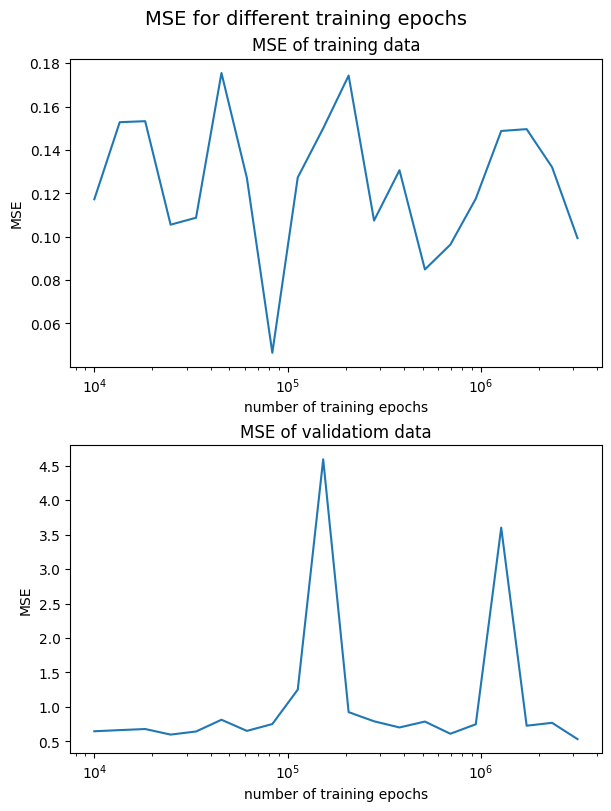

In [17]:
# Plot the results of the MSE for different epochs
arr_epochs = np.logspace(4, 6.5, num=20)
arr_epochs = arr_epochs.astype(np.int64)
fig=plt.figure(figsize=(6,8),layout='constrained')
fig.suptitle(r'MSE for different training epochs', fontsize=14)
ax1=fig.add_subplot(211)
ax1.plot(arr_epochs,arr_mse_train_overfit)
ax1.set_title(r'MSE of training data')
ax2=fig.add_subplot(212)
ax2.plot(arr_epochs,arr_mse_vali_overfit)
ax2.set_title(r'MSE of validatiom data')
for ax in [ax1,ax2]:
    ax.set_xscale('log')
    ax.set_xlabel('number of training epochs')
    ax.set_ylabel('MSE')

### 2.3.3 Evaluate Model: Analysis of a dynamic learning rate

compare MSE over time?